# Testing different interpolation methods

First we'll try to move our current implementation from interpn to use map_coordsinates instead

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html

Then we'll try making severl label slices (not just two)
and using different spline orders (default spline order is 3)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile

%matplotlib inline

In [2]:
import napari

In [3]:
viewer = napari.Viewer()
viewer.open_sample('napari', 'cells3d')
membrane_layer = viewer.layers[0]
nuclei_layer = viewer.layers[1]

In [4]:
original_labels = tifffile.imread('label_fiveslices.tif')
viewer.add_labels(original_labels)
label_layer = viewer.layers[-1]

In [5]:
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import interpn

def distance_transform(image):
    """Distance transform for a boolean image.
    
    Returns positive values inside the object,
    and negative values outside.
    """
    image = image.astype(bool)
    edt = distance_transform_edt(image) - distance_transform_edt(~image)
    return edt


def point_and_values(image_1, image_2, interp_dim=0):
    edt_1 = distance_transform(image_1)
    edt_2 = distance_transform(image_2)
    values = np.stack([edt_1, edt_2], axis=interp_dim)
    points = tuple([np.arange(i) for i in values.shape])
    return points, values


def xi_coords(shape, percent=0.5, interp_dim=0):
    slices = [slice(0, i) for i in shape]
    xi = np.moveaxis(np.mgrid[slices], 0, -1).reshape(np.prod(shape), len(shape)).astype('float')
    xi = np.insert(xi, interp_dim, percent, axis=1)
    return xi


def slice_iterator(slice_index_1, slice_index_2):
    intermediate_slices = np.arange(slice_index_1 + 1, slice_index_2)
    n_slices = slice_index_2 - slice_index_1 + 1  # inclusive
    stepsize = 1 / n_slices
    intermediate_percentages = np.arange(0 + stepsize, 1, stepsize)
    return zip(intermediate_slices, intermediate_percentages)


def interpolated_slice(percent, points, values, interp_dim=0, method='linear'):
    # Find the original image shape
    img_shape = list(values.shape)
    del img_shape[interp_dim]
    # Calculate the interpolated slice
    xi = xi_coords(img_shape, percent=percent, interp_dim=interp_dim)
    interpolated_img = interpn(points, values, xi, method=method)
    interpolated_img = np.reshape(interpolated_img, img_shape) > 0
    return interpolated_img
    

In [6]:
def interpolate_between_slices(label_layer: "napari.layers.Labels", slice_index_1: int, slice_index_2: int, label_id: int =1, interp_dim: int =0):
    if slice_index_1 > slice_index_2:
        slice_index_1, slice_index_2 = slice_index_2, slice_index_1
    layer_data = np.asarray(label_layer.data)
    slice_1 = np.take(layer_data, slice_index_1, axis=interp_dim)
    slice_2 = np.take(layer_data, slice_index_2, axis=interp_dim)
    # slice_1 = np.asarray(label_layer.data[slice_index_1])
    # slice_2 = np.asarray(label_layer.data[slice_index_2])

    #TODO: possible extension, handle all label ids separately     
    slice_1 = slice_1.astype(bool)
    slice_2 = slice_2.astype(bool)
    # interp_dim should just be the slider "dimension" right?
    points, values = point_and_values(slice_1, slice_2, interp_dim)
    #TODO: Thread this?   
    for slice_number, percentage in slice_iterator(slice_index_1, slice_index_2):
        interpolated_img = interpolated_slice(percentage, points, values, interp_dim=interp_dim, method='linear')
        indices = [slice(None) for _ in range(label_layer.data.ndim)]
        indices[interp_dim] = slice_number
        indices = tuple(indices)
        label_layer.data[indices][interpolated_img] = label_id
    label_layer.refresh()  # will update the current view

In [17]:
image_1 = slice_1.astype(bool)
image_2 = slice_2.astype(bool)
edt_1 = distance_transform(image_1)
edt_2 = distance_transform(image_2)
input_array = np.stack([edt_1, edt_2])  # values


In [31]:
coordinates = tuple([np.arange(i) for i in image_1.shape])
coordinates

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [44]:
coordinates = np.array(coordinates)
extra = np.full((1, 256), 0.5)
print(coordinates.shape)
print(extra.shape)
coords = np.concatenate([extra, coordinates], axis=0)
print(coords.shape)

(2, 256)
(1, 256)
(3, 256)


TypeError: Invalid shape (256,) for image data

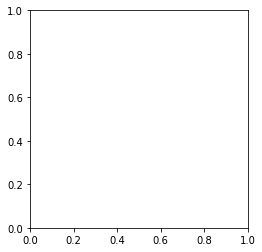

In [48]:
result = map_coordinates(input_array, coords, order=3)
plt.imshow(result)

In [49]:
result.shape

(256,)

In [7]:
label_layer = viewer.layers[-1]
slice_index_1 = 24
slice_index_2 = 30
slice_index_3 = 35
slice_index_4 = 40
slice_index_5 = 45
slices_indices = [24, 30, 35, 40, 45]
#get layers at these slices
# add the an empty 3d volume (or same size) (np.zeroes)
from scipy.ndimage import map_coordinates
interp_dim = 0
empty_cube = np.zeros(shape=(60, 256, 256), dtype="uint8")

slice_1 = np.take(label_layer.data, slice_index_1, axis=interp_dim)
slice_2 = np.take(label_layer.data, slice_index_2, axis=interp_dim)
slice_3 = np.take(label_layer.data, slice_index_3, axis=interp_dim)
slice_4 = np.take(label_layer.data, slice_index_4, axis=interp_dim)
slice_5 = np.take(label_layer.data, slice_index_5, axis=interp_dim)

empty_cube[slice_index_1] = slice_1
empty_cube[slice_index_2] = slice_2
empty_cube[slice_index_3] = slice_3
empty_cube[slice_index_4] = slice_4
empty_cube[slice_index_5] = slice_5

# import tifffile as t
# t.imwrite("label_fiveslices", empty_cube)


In [25]:
# interpolate_between_slices(label_layer, slice_index_1, slice_index_2, interp_dim=0)

In [8]:
image_slices = [slice_1, slice_2, slice_3, slice_4, slice_5]
edts = []
for image_slice in image_slices:
    edts.append(distance_transform(image_slice.astype(bool)))

In [11]:
values = np.array(image_slices)

In [12]:
coordinates = tuple([np.arange(i) for i in values.shape])
# Try next, set first coordinates array equal to the slice number

(array([0, 1, 2, 3, 4]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172